# Reinforcement Learning Lab: Tic-Tac-Toe with SARSA
<img src="../images/tictactoe.png" alt="Tic Tac Toe Example" width="200"/>

**What is this lab about?**  

In this lab, we’ll train an **RL agent** to play **Tic-Tac-Toe** using the **SARSA algorithm**.  
SARSA is an **on-policy** algorithm, meaning it updates Q-values using the action actually taken, not the best future action.  

We will focus on:  

- Understanding the **SARSA update rule**.  
- Implementing the agent.  
- Training against a random opponent.  
- Visualizing results.  

---

## Table of Contents  

- [1 - Packages](#1)  
- [2 - Tic-Tac-Toe Environment](#2)  
- [3 - SARSA Agent](#3)  
- [4 - Training Loop](#4)  
- [5 - Plotting Results](#5)  
- [6 - Evaluation](#6)  
- [7 - Exercises](#7)  
 


# <a name='1'></a>
## 1 - Packages

We start by importing the necessary Python libraries.  

- **numpy** → for handling states and arrays.  
- **random** → for exploration and opponent’s random moves.  
- **matplotlib** → for plotting training results later.  
- **collections** → for tracking performance statistics (wins, draws, losses).  

These will be the main dependencies throughout the notebook.


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict, deque


# <a name='2'></a>
## 2 - Tic-Tac-Toe Environment  

We now create the **game environment** where our RL agent will play.  

### Board Representation  
- The board is a flat array of 9 cells.  
- Values:  
  - `0` → empty cell  
  - `1` → agent (X)  
  - `-1` → opponent (O)  

<img src="../images/tictactoe-board.png" width="250"/>  

### Environment Mechanics  
- `reset()` → clears the board.  
- `available_actions()` → returns indices of empty cells.  
- `step(action, player)` → executes a move, returns `(new_state, reward, done)`.  
- `check_winner()` → checks rows, columns, diagonals.  

### Rewards  
- `+1` → agent wins  
- `-1` → agent loses  
- `0` → draw  
- `-10` → illegal move (placing in occupied cell)  

This environment will be used for both Q-Learning and SARSA.


In [3]:
# <a name='3'></a>
## 3 - Q-Learning Agent

import random
from collections import defaultdict

class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.alpha = alpha        # learning rate
        self.gamma = gamma        # discount factor
        self.epsilon = epsilon    # exploration rate
        self.Q = defaultdict(float)

    def choose_action(self, state, actions, training=True):
        """Choose an action using epsilon-greedy strategy"""
        if training and random.random() < self.epsilon:
            return random.choice(actions)  # exploration
        q_values = [self.Q[(state, a)] for a in actions]
        max_q = max(q_values)
        best_actions = [a for a, q in zip(actions, q_values) if q == max_q]
        return random.choice(best_actions)  # exploitation

    def update(self, state, action, reward, next_state, next_actions):
        """Update Q-values using the Q-learning update rule"""
        best_next_q = max([self.Q[(next_state, a)] for a in next_actions], default=0)
        td_target = reward + self.gamma * best_next_q
        td_error = td_target - self.Q[(state, action)]
        self.Q[(state, action)] += self.alpha * td_error


<a name='4'></a>
## 4 - Running Episodes  

Now we combine the **environment** and the **Q-learning agent** to simulate games.  

### Training Loop  

At each episode:  
1. Reset the environment to get the initial state.  
2. Let the agent play until the game ends (`done=True`).  
3. At each step:  
   - Choose action $a$ using $\epsilon$-greedy.  
   - Apply action → get $(s', r, \text{done})$.  
   - Update $Q(s,a)$ using the Q-learning update rule.  
4. Track results: win, loss, or draw.  

<img src="../images/episode-loop.png" width="400"/>  

This loop allows the agent to **learn from repeated games** and gradually improve.  


In [6]:
# <a name='4'></a>
## 4 - Running Episodes

def run_episode(env, agent, training=True):
    state = env.reset()
    done = False
    total_reward = 0
    player = 1  # agent always starts as X

    while not done:
        actions = env.available_actions()
        action = agent.choose_action(state, actions, training)

        # Take step
        next_state, reward, done = env.step(action, player)
        next_actions = env.available_actions() if not done else []

        if training:
            agent.update(state, action, reward, next_state, next_actions)

        state = next_state
        total_reward += reward

        # Switch player
        player = -player  

    return total_reward, env.winner


def train(env, agent, episodes=500):
    rewards = []
    wins = 0

    for ep in range(episodes):
        total_reward, winner = run_episode(env, agent, training=True)
        rewards.append(total_reward)
        if winner == 1:  # agent (X) wins
            wins += 1

    return rewards, wins


### Test Run  

Let’s train the agent for a few episodes and see if it starts to improve.  

We’ll:  
- Train for 100 episodes.  
- Print how many games the agent **won**.  
- Later, we’ll visualize the results with plots.  


In [7]:
# Quick test run
env = TicTacToe()
agent = QLearningAgent(alpha=0.1, gamma=0.9, epsilon=0.2)

rewards, wins = train(env, agent, episodes=100)

print(f"Total episodes: 100")
print(f"Wins by agent (X): {wins}")
print(f"Win rate: {wins/100:.2f}")


Total episodes: 100
Wins by agent (X): 60
Win rate: 0.60


<a name='5'></a>
## 5 - Plotting Results  

To understand how our agent is improving, we need to **visualize the training progress**.  

We’ll plot:  
- **Rewards per Episode** → shows how the agent’s returns evolve.  
- **Rolling Average Rewards** → smooths out randomness and shows overall trends.  
- **Win Rate Curve** → how often the agent wins as training progresses.  

These plots help us verify if the Q-learning agent is actually **learning** or just playing randomly.  

<img src="../images/qlearning-training-curve.png" width="400"/>  


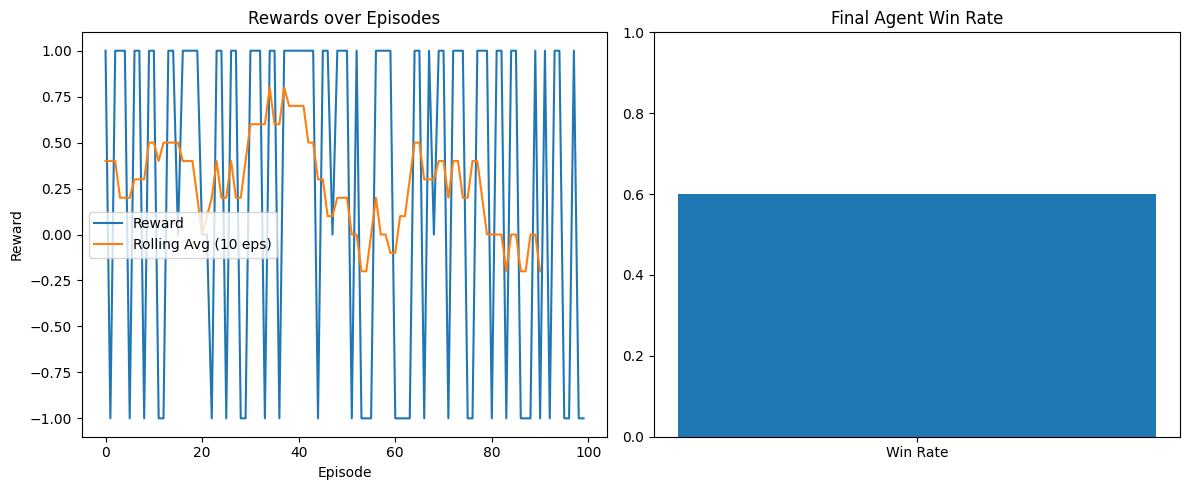

In [9]:
plt.figure(figsize=(12,5))

# Rewards per episode
plt.subplot(1,2,1)
plt.plot(rewards, label="Reward")
rolling_avg = np.convolve(rewards, np.ones(10)/10, mode='valid')
plt.plot(range(len(rolling_avg)), rolling_avg, label="Rolling Avg (10 eps)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Rewards over Episodes")
plt.legend()

# Final Win Rate
plt.subplot(1,2,2)
plt.bar(["Win Rate"], [wins/len(rewards)])
plt.ylim(0,1)
plt.title("Final Agent Win Rate")

plt.tight_layout()
plt.show()


<a name='6'></a>
## 6 - Exercises 🎯  

Now that you have built and trained a **Q-Learning agent** for Tic-Tac-Toe, try the following extensions:

1. **Vary Hyperparameters**  
   - Change $\alpha$, $\gamma$, or $\epsilon$ and see how training performance changes.  
   - Plot and compare learning curves.  

2. **Play Against the Agent**  
   - Implement a simple text-based or GUI interface.  
   - Try playing against your trained agent. Can you beat it?  

3. **Implement SARSA**  
   - Replace the Q-learning update with the SARSA update:  
   $$
   Q(s,a) \gets Q(s,a) + \alpha \Big[ r + \gamma Q(s',a') - Q(s,a) \Big]
   $$  
   - Compare results with Q-Learning.  

4. **Add a Deep Q-Network (DQN)**  
   - Replace the Q-table with a neural network.  
   - Train it using the same environment.  

5. **Experiment with Exploration**  
   - Try different exploration strategies (e.g., decaying $\epsilon$, softmax).  
   - Observe how agent behavior changes.  

6. **Deployment Idea 💡**  
   - Wrap your trained agent in an API.  
   - Build a small GUI so humans can play against it.  
